## Imports

In [1]:
import os

import pandas as pd
import numpy as np
import scipy as stats
import pyarrow as pr
import joblib
import time
import bisect
import gc
import sklearn.metrics as mtrcs
from scipy import stats

import calendar

from tqdm import tqdm
from datetime import datetime

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn.metrics import f1_score, accuracy_score, \
roc_auc_score, classification_report, r2_score, precision_score, recall_score, \
log_loss

import warnings
warnings.filterwarnings("ignore");

RAND = 10
N_FOLDS = 5

# Задача соревнования
Определение **пола** и **возраста** владельца HTTP cookie по истории активности пользователя в интернете на основе синтетических данных.

## Проверка решений
* Решения проверяются автоматически. Запуск происходит на полностью закрытых тестовых данных, которые не передаются участникам.
* На лидерборде рейтинг участников будет рассчитываться по подвыборке ответов из тестовых данных.
* Кол-во сабмитов в день: 3
* Метрика соревнования — **ROC-AUC** – для определения **пола**, **f1 weighted** – для определения **возраста**. **Все решения рассчитываются по формуле -  2 * f1_weighted(**по 6 возрастным бакетам**) + gini по полу.**
* Возрастные бакеты( Класс 1 —19-25, Класс 2 —26-35, Класс 3 —36-45, Класс 4 —46-55, Класс 5 —56-65, Класс 6— 66+)

# Описание данных

Материалы (1 415 MB)

public_train.pqt
3 MB	

competition_data_final_pqt.zip
1 405 MB	

Context_Baseline_Public.ipynb
1 MB	

submit_2.pqt
в этом файле id, по которым нужно предсказать пол и возраст
2 MB	

sample_submission.csv
По возрасту классы: Класс 1 —19-25, Класс 2 —26-35, Класс 3 —36-45, Класс 4 —46-55, Класс 5 —56-65, Класс 6— 66+ 
4 MB

**Описания полей**

- Описание колонок файла с данными:

- 'region_name' – Регион

- 'city_name' – Населенный пункт

- 'cpe_manufacturer_name' – Производитель устройства

- 'cpe_model_name' – Модель устройства

- 'url_host' – Домен, с которого пришел рекламный запрос

- 'cpe_type_cd' – Тип устройства (смартфон или что-то другое)

- 'Cpe_model_os_type' – Операционка на устройстве

- 'price' – Оценка цены устройства

- 'date' – Дата

- 'part_of_day' – Время дня (утро, вечер, итд)

- 'request_cnt' – Число запросов одного пользователя за время дня (поле part_of_day)

- 'user_id' – ID пользователя

**Описание колонок файла с таргетами:**

- 'age' – Возраст пользователя

- 'Is_male' – Признак пользователя : мужчина (1-Да, 0-Нет)

- 'user_id' – ID пользователя

---
# Расположение папок с данными

In [2]:
LOCAL_DATA_PATH = "../data"
DATA_FILE = 'competition_data_final_pqt'

# целевые переменные
TARGET_FILE_AGE = 'targets_age_prep.parquet'
TARGET_FILE_MALE = 'targets_is_male_prep.parquet'

# id, по которым нужно предсказать пол и возраст
SUBMIT_FILE = 'submit_2.pqt'

# папка, куда будут сохраняться предобработанные данные
PREP_DATA = 'preprocessed_data'

LOCAL_DATA_PATH_mts = "../data/ml_cup_data"

---
## 4. EDA parts.

### 4.1. Исследование целевых переменных.

### 4.1.1. Целеой признак возраста.

In [3]:
targets = pd.read_parquet(f'{LOCAL_DATA_PATH}/{PREP_DATA}/{TARGET_FILE_AGE}')
targets.tail()

,user_id,age_target
268917,225374,3
268918,25776,0
268919,148131,1
268920,205570,1
268921,103148,5


In [4]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268922 entries, 0 to 268921
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   user_id     268922 non-null  int64
 1   age_target  268922 non-null  int8 
dtypes: int64(1), int8(1)
memory usage: 2.3 MB


In [5]:
targets[['age_target']].describe()

,age_target
count,268922.000000
mean,1.827307
std,1.213645
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


Посмотрим сколько в процентах в каждой возрастной группе.

In [6]:
# segment_values = targets.age_target.value_counts(ascending=True)
# round(segment_values / targets.shape[0], 3) * 100

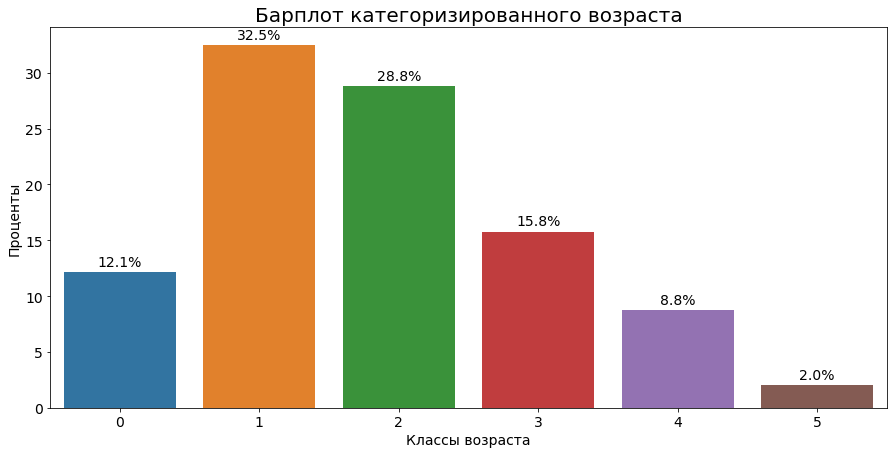

In [7]:
def plot_text(ax: plt.Axes):
    """
    Вывод текста на графике barplot
    """
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=14)
        
        
# нормирование
norm_target = (targets
               .age_target
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

plot_text(ax)

plt.title('Барплот категоризированного возраста', fontsize=20)
plt.xlabel('Классы возраста', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

- **Выводы**: Наблюдается **дисбаланс классов** целеовй переменной **target_age**

<!-- попробую решить это путём стратификации -->

### 4.1.2. Целевой признак по полу.

In [9]:
targets = pd.read_parquet(f'{LOCAL_DATA_PATH}/{PREP_DATA}/{TARGET_FILE_MALE}')
targets.tail()

,user_id,is_male
263503,225374,1
263504,25776,1
263505,148131,0
263506,205570,1
263507,103148,1


In [10]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263508 entries, 0 to 263507
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  263508 non-null  int64
 1   is_male  263508 non-null  int8 
dtypes: int64(1), int8(1)
memory usage: 2.3 MB


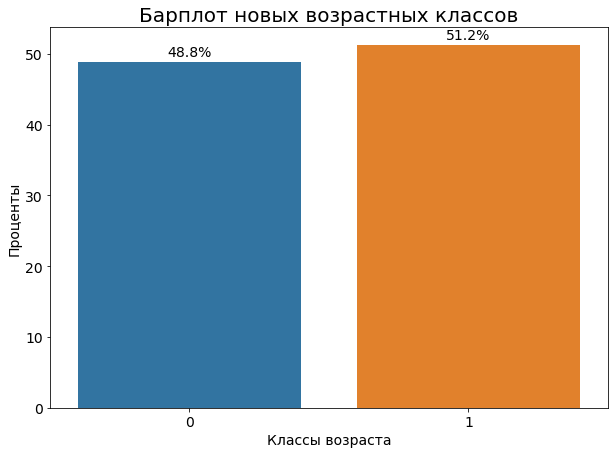

In [12]:
# нормирование
norm_target = (targets
               .is_male
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(10, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

plot_text(ax)

plt.title('Барплот новых возрастных классов', fontsize=20)
plt.xlabel('Классы возраста', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

- **Выводы**: Класс **is_male** довольно **неплохо сбалансирован**!

In [13]:
del targets
gc.collect();

### 4.2. Исследованние не целевых признанков и гипотезы к ним.

In [22]:
# load 
df = pd.read_parquet(f"{LOCAL_DATA_PATH}/{PREP_DATA}/prep_data_with_2_targets.parquet")

In [23]:
df.shape

(263499, 6139)

посмотрим на признаки, которые можно как-то сраввнить друг с другом

In [24]:
df = df[['user_id', 'cpe_manufacturer_name', 'cpe_model_os_type',
    'price', 'day', 'evening', 'morning', 'night',
    'fri', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed',
    'is_male', 'age_target']]
df.tail()

,user_id,cpe_manufacturer_name,cpe_model_os_type,price,day,evening,morning,night,fri,mon,sat,sun,thu,tue,wed,is_male,age_target
263494,415281,LG,Android,3040,1,0,0,0,1,0,0,0,0,0,0,0,5
263495,415287,Huawei,Android,7990,0,0,2,0,0,0,0,0,2,0,0,1,3
263496,415289,Huawei,Android,15326,0,1,0,1,2,0,0,0,0,0,0,1,3
263497,415295,Huawei,Android,8990,0,4,0,0,3,1,0,0,0,0,0,1,2
263498,415311,Huawei,Android,7990,0,1,0,0,0,0,0,0,0,1,0,0,2


### 4.2.1. Гипотеза: гендер или возраст влияет на кол-во переходов по ссылкам.

In [25]:
# подсччёт количества переходов по ссылкам
df['url_count'] = df.loc[:, 'day': 'night'].sum(axis=1)

In [29]:
df[['user_id', 'url_count', 'is_male','age_target']].head()

,user_id,url_count,is_male,age_target
0,4,591,0,1
1,16,1231,0,4
2,18,1125,1,3
3,26,1018,0,4
4,29,1458,0,1


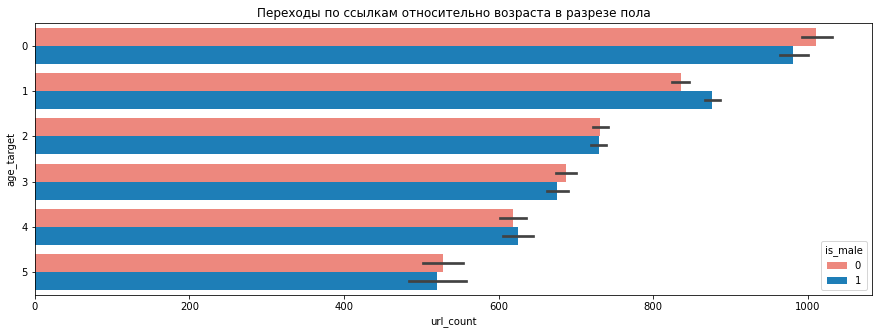

In [12]:
fig = plt.subplots(figsize=(15, 5))

sns.barplot(x='url_count', 
            y='age_target', 
            data=df, 
            hue='is_male',
            palette=["#ff796c", "#0485d1"],
            orient='h').set(title='Переходы по ссылкам относительно возраста в разрезе пола');

- **Выводы**: Видна зависимость - чем **старше пользователь**, тем **меньше переходов по ссылкам** совершает пользователь **вне зависимости от пола**.

### 4.2.2. Гипотеза: стоимость ус-ва влияет на пол или возраст.

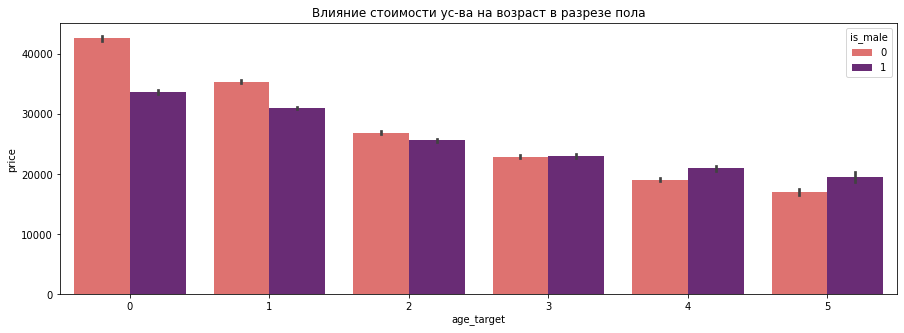

In [31]:
fig = plt.subplots(figsize=(15, 5))

sns.barplot(df, x='age_target', y='price',
            hue='is_male',
            palette='magma_r').set(title='Влияние стоимости ус-ва на возраст в разрезе пола');

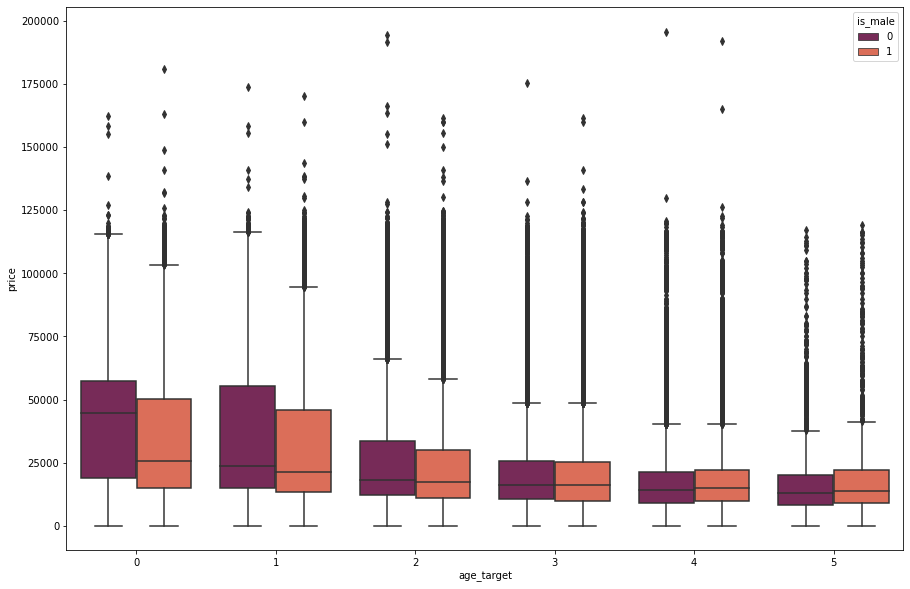

In [14]:
fig = plt.subplots(figsize=(15, 10))

sns.boxplot(df, x='age_target', y='price',
            hue='is_male',
            palette='rocket');

- **Выводы**: Заметно, что у **молодых** пользователей более дорогие ус-ва, чаще у **женского пола**, **с возрастом** тенденция меняется **наоборот**.

### 4.2.3. Гипотеза:  произвоидтель ус-ва влияет на пол или возраст .

In [32]:
df1 = df[['user_id', 
    'cpe_manufacturer_name', 'cpe_model_os_type',
    'is_male', 'age_target']]
df1.tail()

,user_id,cpe_manufacturer_name,cpe_model_os_type,is_male,age_target
263494,415281,LG,Android,0,5
263495,415287,Huawei,Android,1,3
263496,415289,Huawei,Android,1,3
263497,415295,Huawei,Android,1,2
263498,415311,Huawei,Android,0,2


In [33]:
# нормирование по гендеру
norm_target = (df1[['cpe_manufacturer_name','is_male']]
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

norm_target = norm_target.loc[norm_target['percent'] > 1].reset_index()
norm_target['cpe_manufacturer_name'] = norm_target.cpe_manufacturer_name.astype('O')
norm_target

,index,cpe_manufacturer_name,is_male,percent
0,0,Apple,0,16.537824
1,1,Apple,1,15.469888
2,2,Samsung,0,14.031173
3,3,Samsung,1,13.850906
4,4,Huawei,1,11.501751
5,5,Huawei,0,10.688845
6,6,Xiaomi,1,8.656959
7,7,Xiaomi,0,6.429626


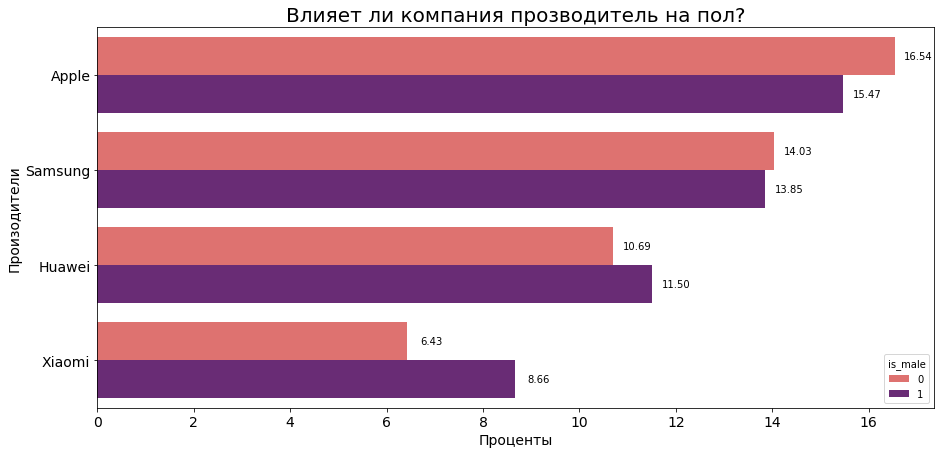

In [41]:
plt.figure(figsize=(15, 7))

ax = sns.barplot(x='percent',
                 y='cpe_manufacturer_name',
                 data=norm_target,
                 hue='is_male',
                 orient='h',
                 palette='magma_r')


for p in ax.patches:
    width = p.get_width()
    plt.text(0.5+p.get_width(), p.get_y()+0.5*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

plt.title('Влияет ли компания прозводитель на пол?', fontsize=20)
plt.xlabel('Проценты', fontsize=14)
plt.ylabel('Произодители', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

- **Вывод**: 1) Можно заметить, как у пользователей **apple** и **samsung** **женщин** **немного больше**, чем мужчин, а у **"китайскиих"** устройств пользователей **мужчин больше**.

In [58]:
# нормирование по возрастным классам
norm_target = (df1[['cpe_manufacturer_name','age_target']]
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

norm_target = norm_target.loc[norm_target['percent'] > 1].reset_index()
norm_target['cpe_manufacturer_name'] = norm_target.cpe_manufacturer_name.astype('O')
norm_target

,index,cpe_manufacturer_name,age_target,percent
0,0,Apple,1,12.573103
1,1,Samsung,2,8.719578
2,2,Samsung,1,8.075173
3,3,Apple,2,7.315777
4,4,Huawei,2,7.214069
5,5,Apple,0,6.814447
6,6,Huawei,1,6.697938
7,7,Samsung,3,5.143094
8,8,Xiaomi,2,4.787115
9,9,Xiaomi,1,4.415577


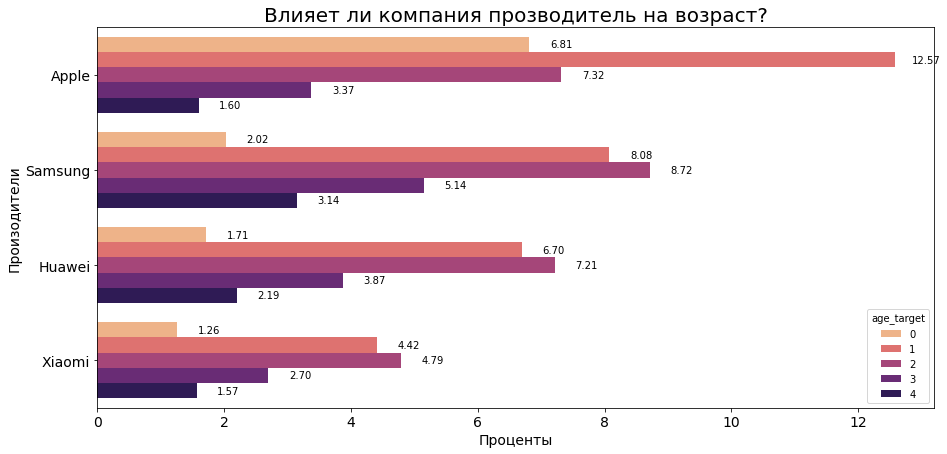

In [59]:
plt.figure(figsize=(15, 7))

ax = sns.barplot(x='percent',
                 y='cpe_manufacturer_name',
                 data=norm_target,
                 hue='age_target',
                 orient='h',
                 palette='magma_r')


for p in ax.patches:
    width = p.get_width()
    plt.text(0.5+p.get_width(), p.get_y()+0.5*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

plt.title('Влияет ли компания прозводитель на возраст?', fontsize=20)
plt.xlabel('Проценты', fontsize=14)
plt.ylabel('Произодители', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

- **Вывод**: 2) Видно, как у **всех возрастных групп** *примерно одинаковая* картина распределения относительно производителей телефонов, но больше всего у apple. Сильно выделяется **apple** у которых **больше всего молодых пользователей** 1 и 2 класса, когда у **samsung** **больше** пользователей **2 и 3** класса.

### 4.2.4. Гипотеза: Операционная система влияет на возраст или пол.

In [50]:
# нормирование по возрастным классам
norm_target = (df[['cpe_model_os_type','age_target']]
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

norm_target = norm_target.loc[norm_target['percent'] > 1].reset_index()
norm_target['cpe_model_os_type'] = norm_target.cpe_model_os_type
norm_target

,index,cpe_model_os_type,age_target,percent
0,0,Android,2,21.637653
1,1,Android,1,19.947324
2,2,iOS,1,12.573103
3,3,Android,3,12.282779
4,4,iOS,2,7.315777
5,5,Android,4,7.220521
6,6,iOS,0,6.814447
7,7,Android,0,5.183321
8,8,iOS,3,3.372688
9,9,Android,5,1.720690


posx and posy should be finite values
posx and posy should be finite values


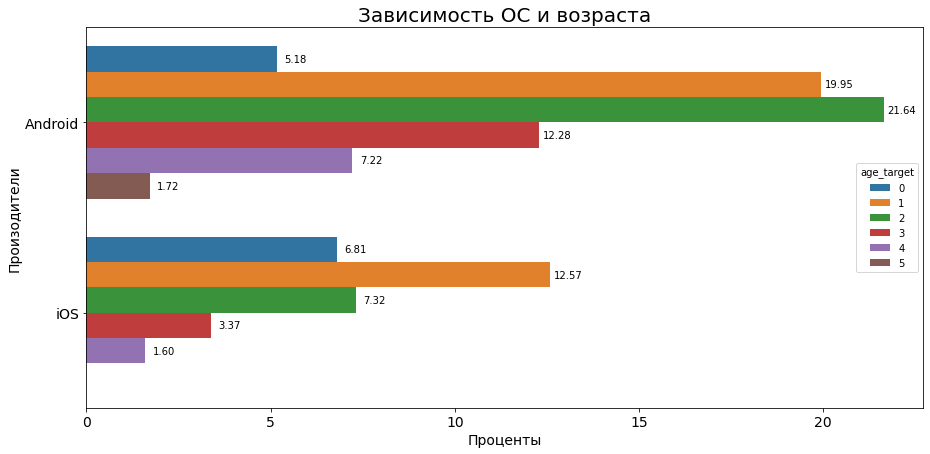

In [51]:
plt.figure(figsize=(15, 7))

ax = sns.barplot(x='percent',
                 y='cpe_model_os_type',
                 data=norm_target,
                 hue='age_target',
                 orient='h')


for p in ax.patches:
    width = p.get_width()
    plt.text(0.5+p.get_width(), p.get_y()+0.5*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

plt.title('Зависимость ОС и возраста', fontsize=20)
plt.xlabel('Проценты', fontsize=14)
plt.ylabel('Произодители', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

**Выводы**: у **android** пользователей сильнее всего **выделяются** возрастные группы **2, 3 и 4 класса**

In [60]:
# нормирование по возрастным классам
norm_target = (df[['cpe_model_os_type','is_male']]
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

norm_target = norm_target.loc[norm_target['percent'] > 1].reset_index()
norm_target['cpe_model_os_type'] = norm_target.cpe_model_os_type
norm_target

,index,cpe_model_os_type,is_male,percent
0,0,Android,1,35.720439
1,1,Android,0,32.271849
2,2,iOS,0,16.537824
3,3,iOS,1,15.469888


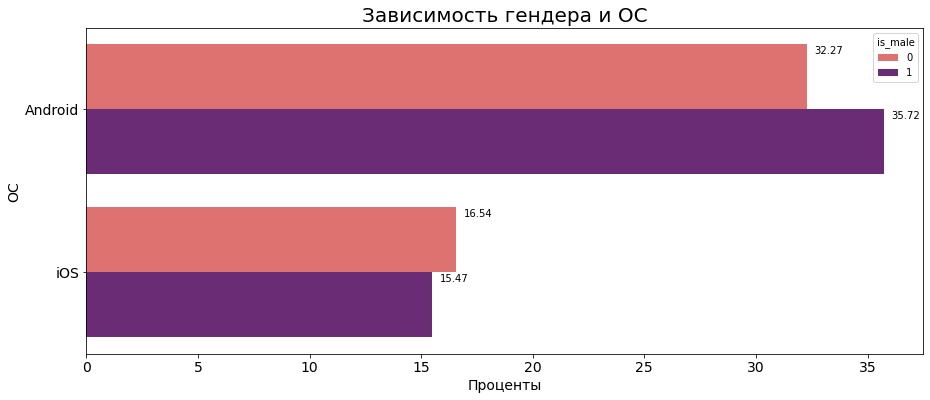

In [62]:
# нормирование
norm_target = (df[['cpe_model_os_type','is_male']]
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 6))

ax = sns.barplot(x='percent',
                 y='cpe_model_os_type',
                 data=norm_target,
                 hue='is_male',
                 orient='h',
                 palette='magma_r')


for p in ax.patches:
    width = p.get_width()
    plt.text(1+p.get_width(), p.get_y()+0.1*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

plt.title('Зависимость гендера и OC', fontsize=20)
plt.xlabel('Проценты', fontsize=14)
plt.ylabel('OC', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

- **Выводы**: В наших данных у пользователей android вдвое больше пользователей мужчин и женщин чем у apple. Так же у пользователей android больше всего мужчин.

- Вывод: В основном на гендерные и возрастные классы большую часть влияют ulr по которым переходят пользователи

---
# 5. ML parts

Продолжение в ноутбуке Train